## Principal Component Analysis (PCA)
A technique of dimensionality reduction, which linearly maps data onto a lower-dimensional space, so that the variance of the projected data in the associated dimensions would be maximized. In this problem, you will perform PCA on a dataset of face images.

In [643]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Read images

(360, 56, 46)

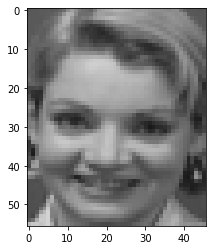

In [672]:
train_X = []
train_y = []
test_X = []
test_y = np.arange(1, 41)
for person in range(1, 41):
    for index in range(1, 10):
        train_X.append(cv2.imread(f"p1_data/{person}_{index}.png", cv2.IMREAD_GRAYSCALE))
    train_y += [person for _ in range(9)]
    test_X.append(cv2.imread(f"p1_data/{person}_10.png", cv2.IMREAD_GRAYSCALE))

train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
# show an example in training set
plt.imshow(train_X[0], cmap='gray', vmin = 0, vmax = 255)
train_X.shape

## Question 1
Perform PCA on the training set. Plot the mean face and the first four eigenfaces.

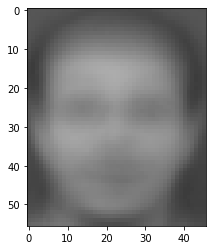

In [573]:
# mean face
plt.imshow(np.mean(train_X, axis=0), cmap='gray', vmin=0, vmax=255)

## PCA on training set

In [675]:
# Reshape each image to a thin vector
N, h, w = train_X.shape 
dim = w * h
train_X = np.reshape(train_X, (N, dim)).T # (features, samples) = (2576, 360) 
test_X = np.reshape(test_X, (test_X.shape[0], dim)).T # (features, samples) = (2576, 40) 

train_X_mean = np.mean(train_X, axis=1, dtype=np.float64)[:, None] # to a column vector
train_Z = train_X - train_X_mean
cov = np.matmul(train_Z, train_Z.T) / N # size = (2576, 2576)
    
# 母體協方差（無biased）, 若為樣本協方差則是除以 (N - 1) 
# 同 np.cov(X, bias=True)

# calculate e-vectors
eigenValues, eigenVectors = LA.eig(cov)
idx = np.argsort(eigenValues)[::-1] # descending order 
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

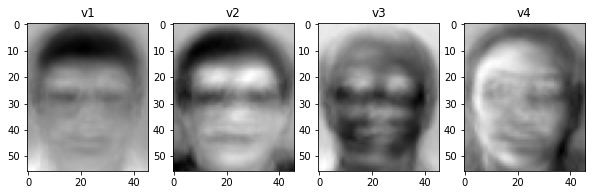

In [676]:
# visualization

plt.figure(figsize=(10, 30))
for i in range(4):
    eigenface = eigenVectors[:, i].real.reshape((h, w))
    plt.subplot(1, 4, i+1)
    plt.title(f"v{i+1}")
    plt.imshow(eigenface, cmap='gray')
plt.savefig("first-four-eigenfaces.jpg")

## Question 2 & 3
Project person_8,image_1 onto the PCA eigenspace you obtained above. Reconstruct this image using the first n = 3, 50, 170, 240, 345 eigenfaces. Plot the five reconstructed images.

For each of the five images you obtained in 2., compute the mean squared error (MSE) between the reconstructed image and the original image. Record the corresponding MSE values in your report.

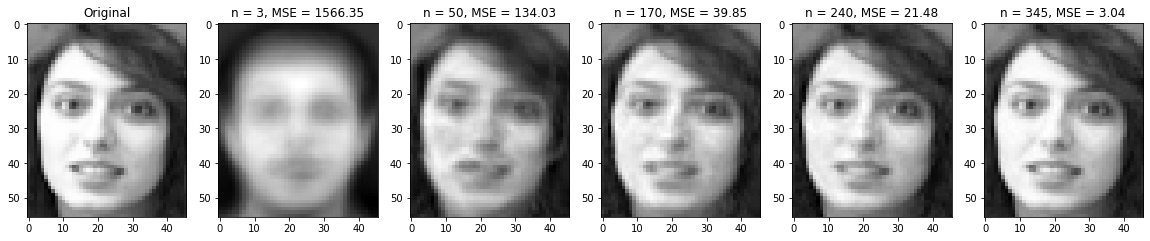

In [677]:
def MSE(A, B):
    return np.mean((A/1 - B/1) ** 2)

def PCA_transform(X, n):
    X = X - train_X_mean
    basis = eigenVectors[:, :n].real # Choose top n eigenvectors as a set basis
    X_reduced = np.matmul(X.T, basis) # (N, 2576) * (2576, n) = (N, n) i.e N samples, n components
    X_reduced = np.matmul(basis, X_reduced.T) + train_X_mean # (2576, n) * (n, N) = (2576, N)
    
    return X_reduced
    
person = 8
index = 1
img_orig = cv2.imread(f"p1_data/{person}_{index}.png", cv2.IMREAD_GRAYSCALE)

img = np.array(img_orig).reshape(1, (h*w)).T # size = (2576, 1)

n_eigenV = [3, 50, 170, 240, 345]
plt.figure(figsize=(20, 100))
plt.subplot(1, 6, 1)
plt.title("Original")
plt.imshow(img_orig, cmap='gray')
for i, n in enumerate(n_eigenV):
    # Calculate the weight in n components respectively
    img_reconstructed = PCA_transform(img , n) # (2576, 1)
    img_reconstructed = np.reshape(img_reconstructed, (h, w))
    mse = np.round(MSE(img_orig, img_reconstructed), 2)
    plt.subplot(1, 6, i+2)
    plt.title(f"n = {n}, MSE = {mse}")
    plt.imshow(img_reconstructed, cmap='gray')

## Question 4
Now, apply the k-nearest neighbors algorithm to classify the testing set images. First, you will need to determine the best k and n values by 3-fold cross-validation. For simplicity, the choices for such hyperparameters are k = {1, 3, 5} and n = {3, 50, 170}. Show the cross- validation results and explain your choice for (k, n).

In [678]:
k_candidates = [1, 3, 5]
n_candidates = [3, 50, 170]
knn = KNeighborsClassifier()
param_grid = {"n_neighbors" : k_candidates}
clf = GridSearchCV(knn, param_grid, cv=3)
print("    k =  1      3      5")
for n in n_candidates:
    # PCA transform
    train_X_reduced = PCA_transform(train_X, n) # size = (2576, 360)
    clf.fit(train_X_reduced.T, train_y)
    # Cross validation
    means = np.round(clf.cv_results_["mean_test_score"], 4)
    print("n=%3d" %n, means)

    k =  1      3      5
n=  3 [0.65   0.6111 0.5611]
n= 50 [0.9611 0.9    0.8472]
n=170 [0.9556 0.8889 0.8222]


## Question 5
Use your hyperparameter choice in 4. and report the recognition rate of the testing set.

In [679]:
k = 1
n = 50
test_X_reduced = PCA_transform(test_X, n) # size = (2576, 40)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_X.T, train_y)
predict_y = knn.predict(test_X_reduced.T)
acc = accuracy_score(y_pred=predict_y, y_true=test_y)
print("Testing accuracy =", acc)

Testing accuracy = 0.9


In [680]:
predict_y

array([ 1,  2,  3,  4, 40,  6,  7,  8,  9, 38, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       16, 36, 37, 38, 39,  5])